In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json('notional_data.json')
df = df.drop(columns=['id', 'user_id', 'created_at', 'updated_at'])
df['severity'] = pd.to_numeric(df['severity'])
df = df.sort_values("date")
df.head()

,date,symptoms,medications,severity
0,2025-03-01,"[itching, dryness]",[Emollient],2
1,2025-03-04,[dryness],[],1
2,2025-03-07,"[itching, redness]",[Hydrocortisone],2
3,2025-03-09,"[itching, redness, dryness]","[Hydrocortisone, Emollient]",3
4,2025-03-11,"[dryness, flaking]",[Emollient],2


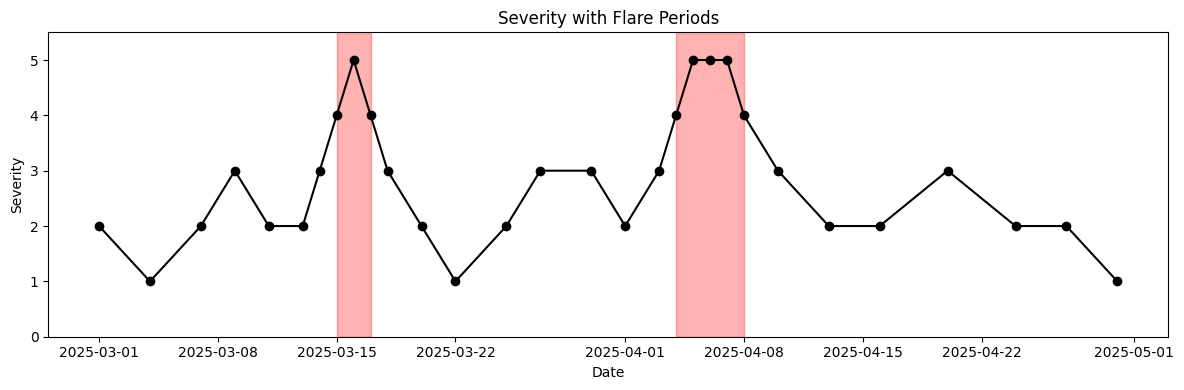

In [3]:
# Flare detection (severity >= 4 for at least 2 consecutive days)
df["is_flare"] = df["severity"] >= 4
df["flare_group"] = (df["is_flare"] != df["is_flare"].shift()).cumsum()
flare_clusters = (
    df[df["is_flare"]]
    .groupby("flare_group")["date"]
    .agg(["min", "max", "count"])
    .rename(columns={"min": "start", "max": "end", "count": "duration"})
)
flare_clusters = flare_clusters[flare_clusters["duration"] >= 2]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["severity"], label="Severity", color="black", marker="o")
for _, row in flare_clusters.iterrows():
    plt.axvspan(row["start"], row["end"], color="red", alpha=0.3)
plt.title("Severity with Flare Periods")
plt.xlabel("Date")
plt.ylabel("Severity")
plt.ylim(0, 5.5)
plt.tight_layout()
plt.show()


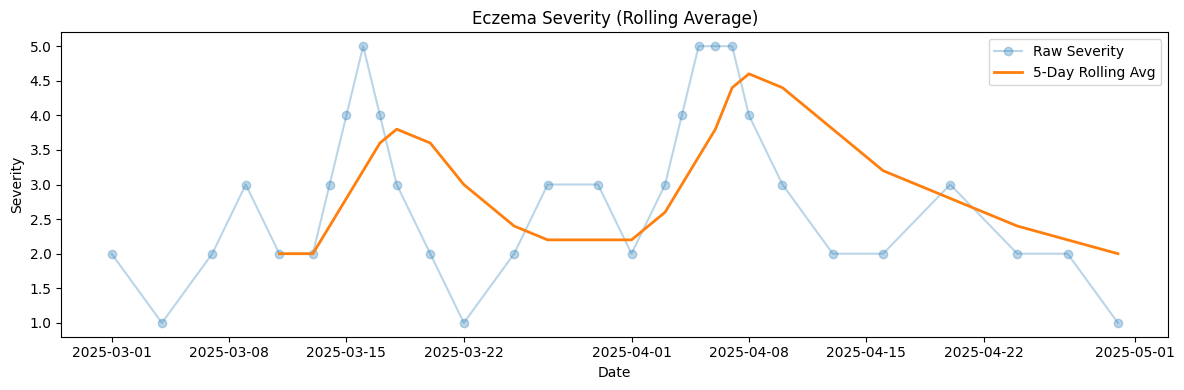

In [4]:
df["rolling_5"] = df["severity"].rolling(window=5).mean()
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["severity"], alpha=0.3, label="Raw Severity", marker="o")
plt.plot(df["date"], df["rolling_5"], label="5-Day Rolling Avg", linewidth=2)
plt.title("Eczema Severity (Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Severity")
plt.legend()
plt.tight_layout()
plt.show()


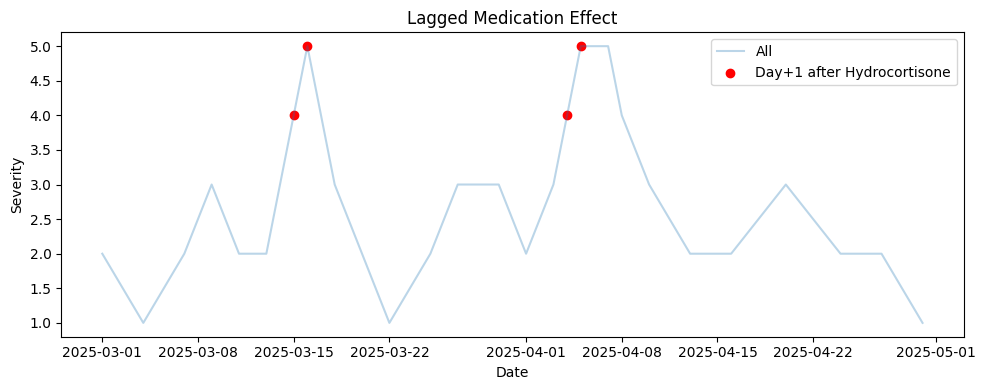

In [7]:
med = "Hydrocortisone"
df["med_used"] = df["medications"].apply(lambda meds: med in meds if isinstance(meds, list) else False)
med_dates = df[df["med_used"]]["date"]
lagged_dates = med_dates + pd.Timedelta(days=1)
lagged_severity = df[df["date"].isin(lagged_dates)][["date", "severity"]]
    
plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["severity"], label="All", alpha=0.3)
plt.scatter(lagged_severity["date"], lagged_severity["severity"], color="red", label=f"Day+1 after {med}")
plt.title("Lagged Medication Effect")
plt.xlabel("Date")
plt.ylabel("Severity")
plt.legend()
plt.tight_layout()
plt.show()


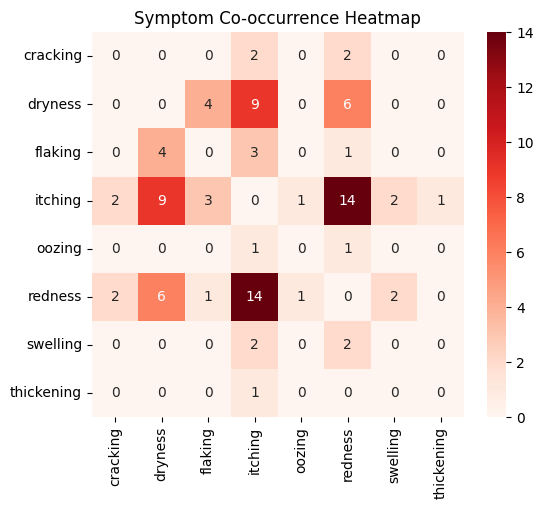

In [8]:
from itertools import combinations
import numpy as np
import seaborn as sns

symptoms = sorted(set(s for sublist in df["symptoms"] for s in sublist))
matrix = pd.DataFrame(0, index=symptoms, columns=symptoms)

for row in df["symptoms"]:
    for s1, s2 in combinations(sorted(row), 2):
        matrix.loc[s1, s2] += 1
        matrix.loc[s2, s1] += 1

plt.figure(figsize=(6, 5))
sns.heatmap(matrix, cmap="Reds", annot=True, fmt="d")
plt.title("Symptom Co-occurrence Heatmap")
plt.show()


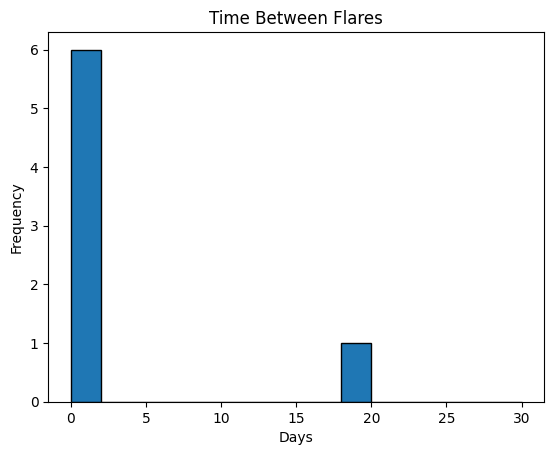

In [9]:
df["is_flare"] = df["severity"] >= 4
flare_days = df[df["is_flare"]]["date"].sort_values()
intervals = flare_days.diff().dt.days.dropna()

plt.hist(intervals, bins=range(0, 31, 2), edgecolor="black")
plt.title("Time Between Flares")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()


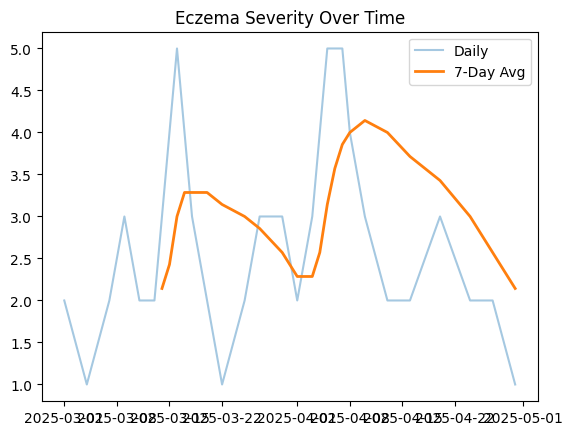

In [10]:
df["rolling_avg"] = df["severity"].rolling(7).mean()
plt.plot(df["date"], df["severity"], label="Daily", alpha=0.4)
plt.plot(df["date"], df["rolling_avg"], label="7-Day Avg", linewidth=2)
plt.legend()
plt.title("Eczema Severity Over Time")
plt.show()


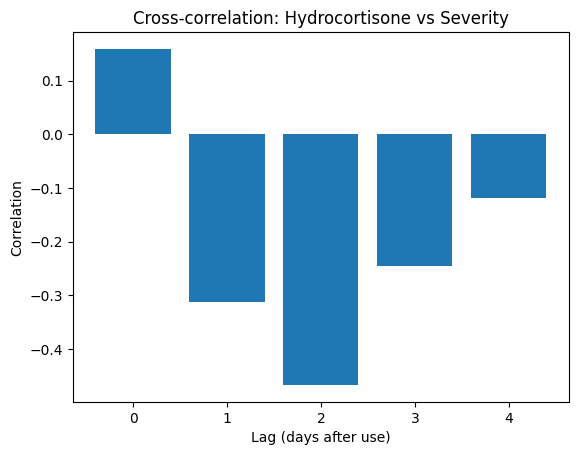

In [12]:
med = "Hydrocortisone"
df["med_used"] = df["medications"].apply(lambda x: med in x if isinstance(x, list) else False).astype(int)

lags = range(0, 5)
correlation = [df["med_used"].shift(-lag).corr(df["severity"]) for lag in lags]

plt.bar(lags, correlation)
plt.title(f"Cross-correlation: {med} vs Severity")
plt.xlabel("Lag (days after use)")
plt.ylabel("Correlation")
plt.show()


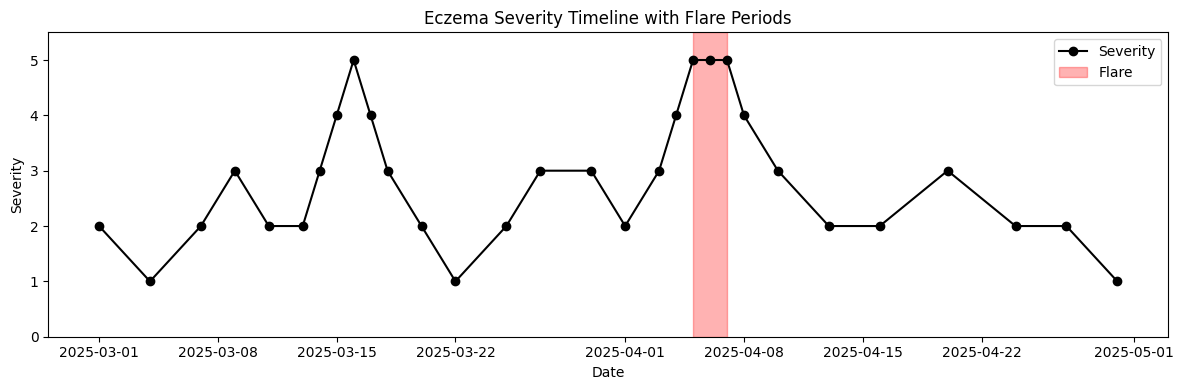

In [39]:
from app.core.flares import detect_flare_clusters
df = pd.read_json('notional_data.json')
flares = detect_flare_clusters(df)

# Plot severity line
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["severity"], label="Severity", marker="o", color="black")

# Plot flare periods
for flare in flares:
    plt.axvspan(
        flare.start,
        flare.end,
        color="red",
        alpha=0.3,
        label="Flare" if flare == flares[0] else None
    )

plt.title("Eczema Severity Timeline with Flare Periods")
plt.xlabel("Date")
plt.ylabel("Severity")
plt.ylim(0, 5.5)
plt.legend()
plt.tight_layout()
plt.show()

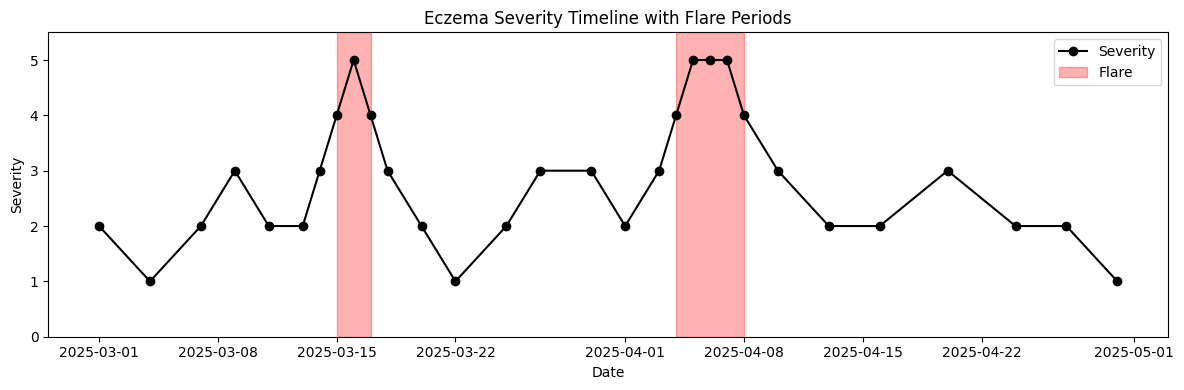

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from app.core.flares import detect_flare_clusters

# Load and prepare data
df = pd.read_json("notional_data.json")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Detect flares
flares = detect_flare_clusters(df, 3, 3)

# Plot severity line
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["severity"], label="Severity", marker="o", color="black")

# Plot flare periods
for i, flare in enumerate(flares):
    plt.axvspan(
        flare.start,
        flare.end,  # Ensure the end date is visible
        color="red",
        alpha=0.3,
        label="Flare" if i == 0 else None  # only label first one
    )

# Final touches
plt.title("Eczema Severity Timeline with Flare Periods")
plt.xlabel("Date")
plt.ylabel("Severity")
plt.ylim(0, 5.5)
plt.legend()
plt.tight_layout()
plt.show()
